 Master Equation in Rb87, D1
 ----------------------------


 # Init

In [1]:
import plotly.express as px
from my_matrix_plot import matrixplot
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy.constants as constants
from sympy.physics.wigner import wigner_6j, wigner_3j
import numpy as np
from qutip import *
# about()
import random

random.seed(389)
qutip.settings.auto_tidyup = True
# from sympy.physics.wigner import clebsch_gordan


mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (10, 4.8)

sns.set_style("dark")

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (10, 4.8)


def F_mF_to_index(F, mF, excited=False):  # only D1 at the moment
    if excited:
        offset = 8
    else:
        offset = 0
    if F == 1:
        return F + mF + offset
    elif F == 2:
        return F + mF + 3 + offset
    else:
        raise NotImplementedError


def index_to_F_mF_string(ind):
    if ind < 3:
        return rf"""$F=1, m={ind - 1}$"""
    elif ind < 8:
        return rf"""$F=2, m={ind - 2 - 3}$"""
    elif ind < 8 + 3:
        return rf"""$F'=1, m={ind - 1 - 8}$"""
    else:
        return rf"""$F'=2, m={ind - 2 - 8 - 3}$"""


def maplot(op: Qobj, std_xlabels=True, std_ylabels=True, annot=False):
    return matrixplot(
        op,
        xlabels=[index_to_F_mF_string(ind) for ind in range(op.shape[0])]
        if std_xlabels
        else "auto",
        ylabels=[index_to_F_mF_string(ind) for ind in range(op.shape[0])]
        if std_ylabels
        else "auto",
        annot=annot,
    )


A_S = 3.417341305452145e09  # Hz
A_P12 = 407.25e6
pi = np.pi
I = 3 / 2
Jg = 1 / 2
Je = 1 / 2  # D1


def Fg1_projector():
    return sum([basis(16, k).proj() for k in range(3)])


def Fg2_projector():
    return sum([basis(16, k).proj() for k in range(3, 8)])


def Fe1_projector():
    return sum([basis(16, k).proj() for k in range(8, 11)])


def Fe2_projector():
    return sum([basis(16, k).proj() for k in range(11, 16)])


def j_1_2_projector():
    return sum([basis(16, k).proj() for k in range(8)])


def j_3_2_projector():
    return sum([basis(16, k).proj() for k in range(8, 16)])


def Eg(F):
    return 1 / 2 * A_S * (F * (F + 1) - I * (I + 1) - Jg * (Jg + 1))


def E_P12(F):
    return 1 / 2 * A_P12 * (F * (F + 1) - I * (I + 1) - Je * (Je + 1))


def Ha(det_Light):
    return (
        sum([(E_P12(1) - det_Light) * basis(16, 8 + m).proj() for m in range(3)])
        + sum([(E_P12(2) - det_Light) * basis(16, 8 + 3 + m).proj() for m in range(5)])
        + sum([Eg(1) * basis(16, m + 1).proj() for m in (-1, 0, 1)])
        + sum([Eg(2) * basis(16, 3 + m).proj() for m in range(5)])
    )


def sigma_q(
    q,
):  # "weighted lowering operator", m_F = m'_F + q
    assert q in (-1, 0, 1)
    opers = []
    for Fg in (1, 2):
        for mg in range(-Fg, Fg + 1):
            for Fe in (1, 2):
                for me in range(-Fe, Fe + 1):
                    a = (
                        (-1) ** (Fe + Jg + 1 + I)
                        * ((2 * Fe + 1) * (2 * Jg + 1)) ** (1 / 2)
                        * (-1) ** (Fe - 1 + mg)
                        * (2 * Fg + 1) ** (1 / 2)
                        * float(wigner_3j(Fe, 1, Fg, me, q, -mg))
                        * float(wigner_6j(Je, Jg, 1, Fg, Fe, I))
                    )
                    op = (
                        basis(16, F_mF_to_index(Fg, mg))
                        * basis(16, F_mF_to_index(Fe, me, excited=True)).dag()
                    )
                    opers.append(a * op)
    return sum(opers)


def rabi(intens):  # Jg = Je = 1/2  -> only D1 and sigma+/- polarization (E_total = E_q)
    return (
        -((2 * intens / (constants.c * constants.epsilon_0)) ** (1 / 2))
        * 2.5377e-29
        / constants.h  # dipole transition matrix element
    )


def H_AF(q, intens):
    tmp = np.conjugate(rabi(intens)) * sigma_q(q)
    return tmp + tmp.dag()


OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL = 4.4876 * 1e-3 / (1e-2) ** 2
# far detuned saturation intensity for D1, pi pol. Is this value even relevant for pumping ?

F2_FP1_FREQUENCY = -509.06e6 - 2.563005979089109e9


def sigma_pm_pump_D1(
    detuning, q=-1, laser_intens=1 * OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL
):
    return Ha(detuning) + H_AF(q, laser_intens)


GAMMANATURAL = 5.7500e6  # D1


def natural_decay_ops():
    return [GAMMANATURAL ** (1 / 2) * sigma_q(q) for q in [-1, 0, 1]]


def intra_F1(gamma=1e4):
    return [
        sum(
            [
                (gamma / 3) ** (1 / 2) * basis(16, f) * basis(16, i).dag()
                for f in range(3)
                if i != f
            ]
        )
        for i in range(3)
    ]


def intra_F2(gamma=1e4):
    return [
        sum(
            [
                (gamma / 5) ** (1 / 2) * basis(16, f) * basis(16, i).dag()
                for f in range(3, 8)
                if i != f
            ]
        )
        for i in range(3, 8)
    ]


def intra_Fp1(gamma=1e4):
    return [
        sum(
            [
                (gamma / 3) ** (1 / 2) * basis(16, f) * basis(16, i).dag()
                for f in range(8, 3 + 8)
                if i != f
            ]
        )
        for i in range(8, 3 + 8)
    ]


def intra_Fp2(gamma=1e4):
    return [
        sum(
            [
                (gamma / 5) ** (1 / 2) * basis(16, f) * basis(16, i).dag()
                for f in range(3 + 8, 8 + 8)
                if i != f
            ]
        )
        for i in range(3 + 8, 8 + 8)
    ]


def F2_to_F1_decay_ops(gamma=1e4):
    return [
        (gamma / 3) ** (1 / 2)
        * sum([basis(16, f) * basis(16, i).dag() for f in range(3)])
        for i in range(5)
    ]


QUENCHING_RATE = 8.4e7 / (2 * pi)


def quenching_ops():
    return [
        sum(
            [
                (QUENCHING_RATE / 8) ** (1 / 2) * basis(16, g) * basis(16, e).dag()
                for g in range(8)
            ]
        )
        for e in range(8, 16)
    ]


def plot_ground_states_time(res_):
    ground_exp_val_ = [
        [
            res_.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for t in range(len(res_.times))
        ]
        for i in range(8)
    ]
    fig, axs = plt.subplots(
        ncols=5, nrows=2, figsize=(12, 6), sharex="all", sharey="all"
    )
    for i, e in enumerate(ground_exp_val_[:3]):
        axs[1, 1 + i].plot(res_.times, np.real(e))
    for i, e in enumerate(ground_exp_val_[3:8]):
        axs[0, i].plot(res_.times, np.real(e))
    fig.suptitle("Ground States")
    axs[1, 2].set_xlabel("Time (s)")
    plt.tight_layout()
    return fig, axs

def plot_excited_states_time(res_):
    excited_exp_val_ = [
        [
            res_.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for t in range(len(res_.times))
        ]
        for i in range(8, 16)
    ]
    fig, axs = plt.subplots(
        ncols=5, nrows=2, figsize=(12, 6), sharex="all", sharey="all"
    )
    for i, e in enumerate(excited_exp_val_[:3]):
        axs[1, 1 + i].plot(res_.times, np.real(e))
    for i, e in enumerate(excited_exp_val_[3:8]):
        axs[0, i].plot(res_.times, np.real(e))
    fig.suptitle("Excited States")
    axs[1, 2].set_xlabel("Time (s)")
    plt.tight_layout()
    return fig, axs


def bar_plot_pops(dens):
    pops = list(dens.diag())
    x_ = [f"$m_F = {i}$" for i in range(-2, 3)]
    fig, axs = plt.subplots(nrows=4, figsize=(8, 6), sharex="all")#, sharey="all")
    axs[0].bar(x_,[np.real(e) for e in pops[11:]])
    axs[1].bar(x_,[np.real(e) for e in [0,] + pops[8:11]] + [0,])
    axs[2].bar(x_,[np.real(e) for e in pops[3:8]])
    axs[3].bar(x_,[np.real(e) for e in [0,] + pops[:3]] + [0,])
    
    axs[0].set_title(r"$F' = 2$")
    axs[1].set_title(r"$F' = 1$")
    axs[2].set_title(r"$F = 2$")
    axs[3].set_title(r"$F = 1$")

    axs[1].sharey(axs[0])
    axs[3].sharey(axs[2])
    plt.tight_layout()
    return fig, axs



def plot_superop(L):
    y = L.full().real
    fig = px.imshow(
    y,
    color_continuous_midpoint=0,
    aspect="equal",
    width=1.5 * 800,
    height=1.5 * 400,
    zmin=-(abs(y).max()),
    zmax=(abs(y).max()),
    color_continuous_scale="RdBu",
    )
    fig.show()

def get_equally_ground_state():
    return sum([basis(16, i).proj() for i in range(8)]).unit()


def plot_ground_excited(res_, gamma=None):
    times = res_.times
    total_ground_exp = [
        sum(
            [
                res_.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
                for i in range(8)
            ]
        )
        for t in range(len(times))
    ]
    total_exc_exp = [
        sum(
            [
                res_.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
                for i in range(8, 16)
            ]
        )
        for t in range(len(times))
    ]   
    fig, ax = plt.subplots()
    ax.plot(times, np.real(total_ground_exp), label="Ground")
    ax.plot(times, np.real(total_exc_exp), label="Excited")
    if gamma:
        ax.plot(
        times, [np.exp(-gamma * t)*total_exc_exp[0] for t in times], "--", label=r"$e^{-\Gamma t} P_e$"
        )
    ax.set_xlabel("Time (s)")
    ax.legend()
    plt.tight_layout()
    return fig, ax


 ## D1 Resonant Driving F=2 --> F', No Decay

 Starting state: equal population in ground states

In [ ]:
hamil = sigma_pm_pump_D1(F2_FP1_FREQUENCY)
starting_state = sum([basis(16, i).proj() for i in range(8)]).unit()
times = np.linspace(0, 1e-6, 1000)

opts = Options(nsteps=2 * 10**4)
res = mesolve(
    hamil,
    starting_state,
    times,
    options=opts,
)

In [ ]:
plot_excited_states_time(res)
plot_ground_states_time(res)


 ## D1 Off-Resonant (-1 GHz) Driving F=2 --> F', No Decay

 Starting state: equal population in ground states

In [ ]:
hamil_off = sigma_pm_pump_D1(F2_FP1_FREQUENCY - 1e9)
starting_state = sum([basis(16, i).proj() for i in range(8)]).unit()
times = np.linspace(0, 1e-6, 1000)

opts = Options(nsteps=2 * 10**4)
res = mesolve(
    hamil_off,
    starting_state,
    times,
    options=opts,
)


In [ ]:
plot_excited_states_time(res)
plot_ground_states_time(res)

 # Radiative Decay Only

In [ ]:
lind = sum([lindblad_dissipator(a=c) for c in natural_decay_ops()])


In [ ]:
plot_superop(lind)

 ### $T = 10\, ns$

In [ ]:
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    lind,
    rho0=rand_dm(16),
    tlist=times,
    options=opts,
)


In [ ]:
plot_excited_states_time(res)

In [ ]:
plot_ground_states_time(res)


In [ ]:
plot_ground_excited(res)

 # Quenching Only

In [ ]:
maplot(sum(quenching_ops()))



In [ ]:
maplot(quenching_ops()[-1])



In [ ]:
lind = liouvillian(None, c_ops=quenching_ops())


 ## Time Evo

 ### excited state equally populated

In [ ]:
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=2 * 10**4)
res = mesolve(
    lind,
    rand_dm(16),
    times,
    options=opts,
)

In [ ]:
plot_ground_excited(res, gamma=QUENCHING_RATE)
plot_excited_states_time(res)
plot_ground_states_time(res)


 ### $\rho_0 = |F'=2, m'_F=2\rangle$

In [ ]:
starting_state = basis(16, 15).proj()
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=2 * 10**4)
res = mesolve(
    lind,
    starting_state,
    times,
    options=opts,
)



In [ ]:
plot_ground_excited(res, gamma=QUENCHING_RATE)
plot_excited_states_time(res)
plot_ground_states_time(res)


 # Driven By D1 Laser: $\sigma_-$, $|F=2\rangle \rightarrow |F'=1\rangle$, Damped by Radiative Decay

In [2]:
hamil = sigma_pm_pump_D1(F2_FP1_FREQUENCY)
lind = liouvillian(hamil, c_ops=natural_decay_ops())


In [3]:
lind.istp


False

In [4]:
lind.iscp


False

 ### Time Evolution

 #### $T = 10\, \mu s$

In [5]:
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=2 * 10**4)
res = mesolve(
    lind,
    get_equally_ground_state(),
    times,
    options=opts,
)



(<Figure size 864x432 with 10 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='Time (s)'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

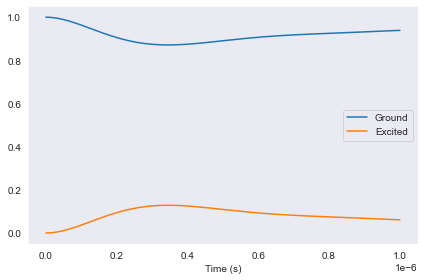

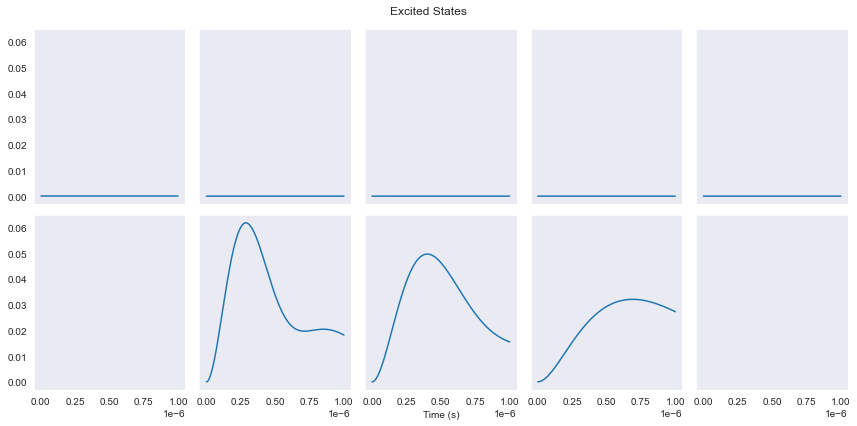

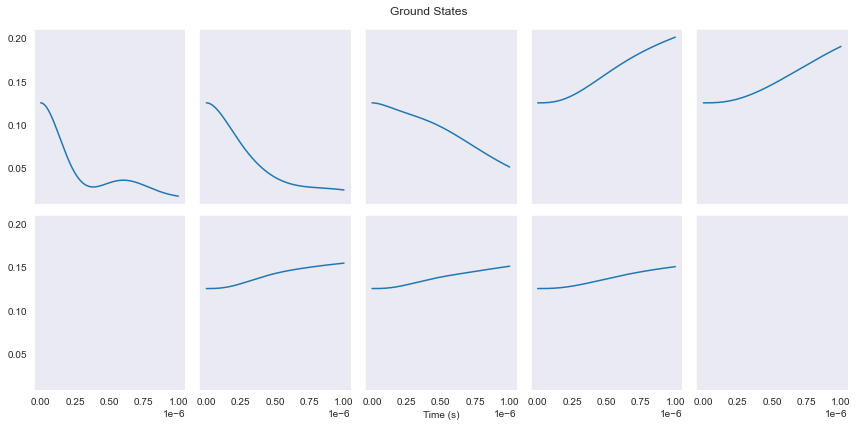

In [6]:
plot_ground_excited(res)
plot_excited_states_time(res)
plot_ground_states_time(res)




 #### $T = 10\, ms$

In [7]:
times = np.linspace(0, 1e-4, 1000)
opts = Options(nsteps=2 * 10**4)
res = mesolve(
    lind,
    get_equally_ground_state(),
    times,
    options=opts,
)



(<Figure size 864x432 with 10 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='Time (s)'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

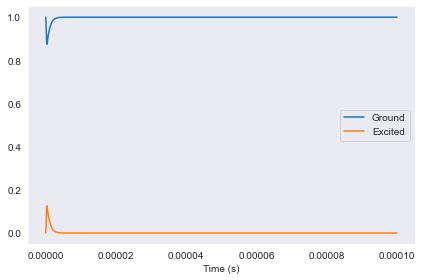

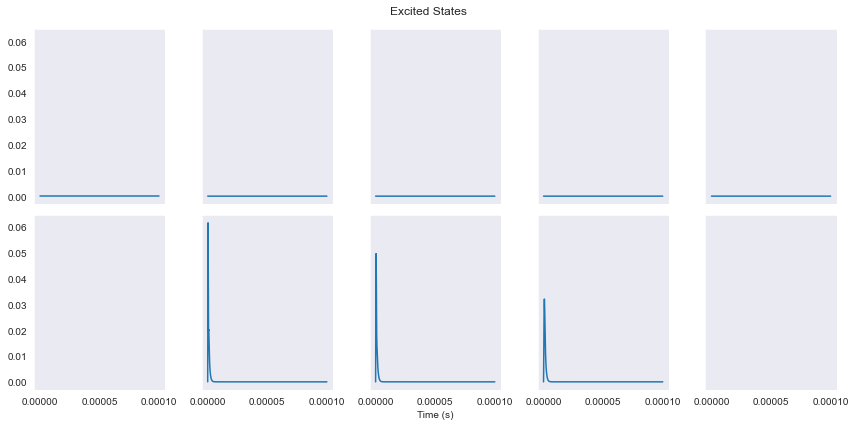

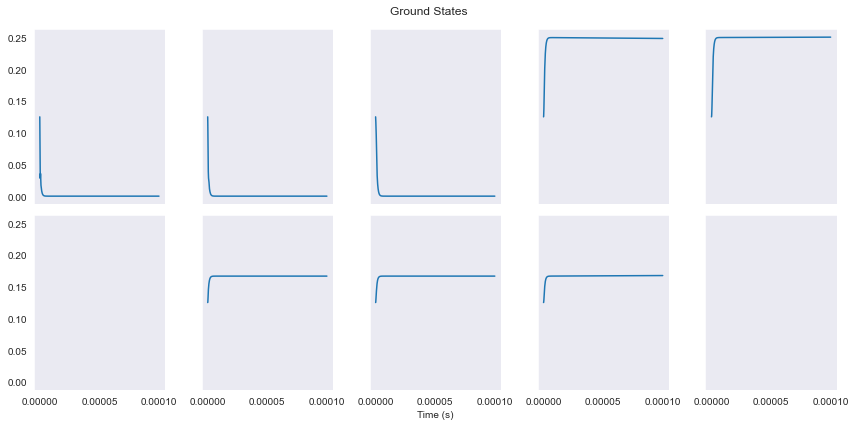

In [8]:
plot_ground_excited(res)
plot_excited_states_time(res)
plot_ground_states_time(res)




 ### Steady State

 #### Lindblad Superoperator

 Matrix representation of operators are transformed to vectors by column-stacking.

In [ ]:
operator_to_vector(basis(2, 0) * basis(2, 1).dag())


 ##### A Steady State for $\sigma_+$ pump is the dark state $|F=2, m_F=2 \rangle$

In [ ]:
lind = liouvillian(hamil, c_ops=natural_decay_ops())
lenergy, lstates = lind.eigenstates()
rho_ss_zero_eigenval = vector_to_operator(lstates[np.abs(lenergy).argmin()])
maplot(rho_ss_zero_eigenval)

In [ ]:
rho_ss_dot = lind * operator_to_vector(rho_ss_zero_eigenval)
maplot(vector_to_operator(rho_ss_dot))



 #### Several Steady-State Solvers



In [ ]:
rho_ss_direct = steadystate(lind, method="direct")
maplot(rho_ss_direct)



In [ ]:
rho_ss_power = steadystate(lind, method="power")
maplot(rho_ss_power)


In [ ]:
rho_ss_it_gmres = steadystate(lind, method="iterative-gmres")
maplot(rho_ss_it_gmres)

In [ ]:
rho_ss_it_lgmres = steadystate(lind, method="iterative-lgmres"
)
maplot(rho_ss_it_lgmres)



In [ ]:
rho_ss_it_bicgstab = steadystate(lind, method="iterative-bicgstab")
maplot(rho_ss_it_bicgstab)



In [ ]:
rho_ss_svd = steadystate(lind, method="svd")
maplot(rho_ss_svd)




 # Decay intra F

 $ |F, m_F \rangle \rightarrow |F, m'_F \rangle$ , where $m'_F = -F, ..., F$ and $m_F \neq m'_F$

 Decay operator $C_k = \sqrt{\Gamma_k} \sum_{m'_F\neq k} |F, m'_F \rangle \langle F, m_F=k |$


In [ ]:
maplot(sum(intra_F1() + intra_F2() + intra_Fp1() + intra_Fp2()))



In [ ]:
maplot(intra_F1()[0])


 ## Time Evo

In [ ]:
lind = liouvillian(None, c_ops=intra_F1() + intra_F2() + intra_Fp1() + intra_Fp2())
starting_state = basis(16, 7).proj().unit()
times = np.linspace(0, 1e-3, 1001)
opts = Options(nsteps=1 * 10**6)
res = mesolve(
    lind,
    starting_state,
    times,
    options=opts,
)

In [ ]:
plot_ground_states_time(res)

 ## With Rad Decay

In [ ]:
hamil = sigma_pm_pump_D1(F2_FP1_FREQUENCY)
lind = liouvillian(
    hamil,
    c_ops=intra_F1() + intra_F2() + intra_Fp1() + intra_Fp2() + natural_decay_ops(),
)
L_en, L_states = lind.eigenstates()

In [ ]:
zero_eigenvalue_states = []
for en, st in zip(*lind.eigenstates()):
    if np.isclose(en, 0, atol=1e-5):
        zero_eigenvalue_states.append(vector_to_operator(st))
len(zero_eigenvalue_states)



In [ ]:
trace = zero_eigenvalue_states[0].tr()
maplot(zero_eigenvalue_states[0] / trace)
print(trace)

In [ ]:
rho_steady = zero_eigenvalue_states[0] / trace
rho_steady_dot = vector_to_operator(lind * operator_to_vector(rho_steady))
rho_steady_dot.tr()
maplot(rho_steady_dot)



 ### Time Evo

In [ ]:
times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    lind,
    get_equally_ground_state(),
    times,
    options=opts,
)
plot_excited_states_time(res)
plot_ground_states_time(res)


 # Decay Inter F Ground States

In [ ]:
maplot(sum(F2_to_F1_decay_ops()))
maplot(F2_to_F1_decay_ops()[-1])



In [19]:
tensor(basis(8, 0), 0*basis(16, 1))

Quantum object: dims = [[8, 16], [1, 1]], shape = (128, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

 # Radiative and F to F and F=2 to F=1 and Quenching

In [ ]:
lind = liouvillian(
    hamil,
    c_ops=natural_decay_ops() + intra_F1() + intra_F2() + F2_to_F1_decay_ops() + quenching_ops(),
)



 Real part

In [ ]:

y = lind.full().real
fig = px.imshow(
    y,
    color_continuous_midpoint=0,
    aspect="equal",
    width=1.5 * 800,
    height=1.5 * 400,
    zmin=-(abs(y).max()),
    zmax=(abs(y).max()),
    color_continuous_scale="RdBu",
)
fig.show()



 Imag part

In [ ]:

y = lind.full().imag
fig = px.imshow(
    y,
    color_continuous_midpoint=0,
    aspect="equal",
    width=1.5 * 800,
    height=1.5 * 400,
    zmin=-(abs(y).max()),
    zmax=(abs(y).max()),
    color_continuous_scale="RdBu",
)
fig.show()



In [ ]:
L_eigvals, L_states = lind.eigenstates()
sns.stripplot(data=abs(L_eigvals))



In [ ]:

sorted(abs(L_eigvals))[:10]



In [ ]:
r_zero = L_states[abs(L_eigvals).argmin()]
r_zero = vector_to_operator(r_zero)
maplot(r_zero / r_zero.tr())



 ## Time Evo

In [ ]:
rho_zero = get_equally_ground_state()



In [ ]:
times = np.linspace(0, 1e-6, 1001)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    lind,
    rho_zero,
    times,
    options=opts,
)



In [ ]:
maplot(res.states[-1])



In [ ]:
plot_excited_states_time(res)
plot_ground_states_time(res)
plot_ground_excited(res)


In [ ]:
ground_exp_even = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp_even):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()



In [ ]:
ground_state_tot = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
tot_excited_exp_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
fig, ax = plt.subplots()
ax.plot(times, ground_state_tot, label="ground")
ax.plot(times, tot_excited_exp_even, label="excited + 1")
ax.legend()
plt.tight_layout()



In [ ]:
exc_expeven = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for k, e in enumerate(exc_expeven):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("exc States")
plt.xlabel("Time (s)")

plt.tight_layout()



In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)],
    [np.real(e)[-1] for e in ground_exp_even],
)
plt.title("Ground States at t=T")
plt.tight_layout()



In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    [np.real(e)[-1] for e in exc_expeven],
)
plt.title("Exc States")
plt.tight_layout()



 ## Longer Time Evo

In [ ]:
rho_zero = sum([basis(16, i).proj() for i in range(8)]).unit()  # equally distrib



In [ ]:
times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**4)
res = mesolve(
    lind,
    rho_zero,
    times,
    options=opts,
)



In [ ]:
maplot(res.states[-1])



In [ ]:
res.states[-1].tr()



In [ ]:
ground_exp_even = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp_even):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()



In [ ]:
ground_state_tot = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
tot_excited_exp_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
fig, ax = plt.subplots()
ax.plot(times, ground_state_tot, label="ground")
ax.plot(times, tot_excited_exp_even, label="excited + 1")
ax.legend()
plt.tight_layout()



In [ ]:
exc_expeven = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for k, e in enumerate(exc_expeven):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("exc States")
plt.xlabel("Time (s)")

plt.tight_layout()



In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)],
    [np.real(e)[-1] for e in ground_exp_even],
)
plt.title("Ground States")
plt.tight_layout()



In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    [np.real(e)[-1] for e in exc_expeven],
)
plt.title("Exc States")
plt.tight_layout()



 ## $\rho_0 = |F=2, m_F=-2\rangle$

In [ ]:
rho_zero = sum([basis(16, 3).proj() for i in range(8)]).unit()



In [ ]:
times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**4)
res = mesolve(
    lind,
    rho_zero,
    times,
    options=opts,
)



In [ ]:
maplot(res.states[-1])



In [ ]:
res.states[-1].tr()



In [ ]:
ground_exp_even = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp_even):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()



In [ ]:
ground_state_tot = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
tot_excited_exp_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
fig, ax = plt.subplots()
ax.plot(times, ground_state_tot, label="ground")
ax.plot(times, tot_excited_exp_even, label="excited + 1")
ax.legend()
plt.tight_layout()



In [ ]:
exc_expeven = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for k, e in enumerate(exc_expeven):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("exc States")
plt.xlabel("Time (s)")

plt.tight_layout()



In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)],
    [np.real(e)[-1] for e in ground_exp_even],
)
plt.title("Ground States")
plt.tight_layout()



In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    [np.real(e)[-1] for e in exc_expeven],
)
plt.title("Exc States")
plt.tight_layout()



 # MW Transition

 ## Init

In [ ]:
A = 3.417341305452145e09  # Hz
MU_BOHR = 1.399624604e6  # Hz / G

# uncoupled basis
H_hfs = A * (
    tensor(spin_Jz(3 / 2), spin_Jz(1 / 2))  # I * J (S_1/2, where L=0)
    + tensor(spin_Jy(3 / 2), spin_Jy(1 / 2))
    + tensor(spin_Jx(3 / 2), spin_Jx(1 / 2))
)


def H_B(bx=0, by=0, bz=0):  # in G
    return (
        2.0023193043622
        * (
            tensor(qeye(4), spin_Jx(1 / 2)) * bx
            + tensor(qeye(4), spin_Jy(1 / 2)) * by
            + tensor(qeye(4), spin_Jz(1 / 2)) * bz
        )
        - 0.000995
        * (
            tensor(spin_Jx(3 / 2), qeye(2)) * bx
            + tensor(spin_Jy(3 / 2), qeye(2)) * by
            + tensor(spin_Jz(3 / 2), qeye(2)) * bz
        )
    ) * MU_BOHR


energs, F_states = (H_hfs + H_B(bz=0.1)).eigenstates()
F_states_reordered = [
    F_states[2],
    F_states[1],
    F_states[0],
]  # to have same basis in the same order: |F=1, m=-1>, |F=1, m=0>, ...
for k in range(3, 3 + 5):
    F_states_reordered.append(F_states[k])

# RWA


def h_mw_a(det_mw):
    return sum([(ens[f] - det_mw) * basis(8, f).proj() for f in range(3, 8)]) + sum(
        [ens[f1] * basis(8, f1).proj() for f1 in range(3)]
    )


def B_loop(power_mw, radius=3e-3, distance=0.02):  # in Gauss
    return (
        constants.mu_0
        * radius**2
        * (power_mw / 50) ** (1 / 2)
        / (2 * (distance**2 + radius**2) ** (3 / 2))
        * 1e4
    )


Bmw = B_loop(1e-1)
# transition_coeffs = tensor(qeye(4), spin_Jx(1 / 2)).transform(F_states_reordered)
# det_mw = 0
# rabi_mw = 1e6
H_0 = H_hfs + H_B(bz=0.1)
E_0 = H_0.eigenenergies()[5] - H_0.eigenenergies()[1]  # clock transition
ens = H_0.eigenenergies() - H_0.eigenenergies()[1]
ens = [en if k < 3 else en - E_0 for k, en in enumerate(ens)]
tmp = ens[0]
ens[0] = ens[2]
ens[2] = tmp



In [ ]:
ens



In [ ]:
139912.998503685 - (-70237.18127632141)



In [ ]:
3 * 70235.74342823029



 ### MW Hamiltonian I, J basis and F basis

In [ ]:
hbt = H_B(bx=1, by=0.0, bz=0.0)
fig, _ = matrixplot(hbt, annot=True)
fig.set_size_inches(14, 6)
fig.suptitle("Uncoupled basis I J=1/2")
plt.tight_layout()
fig, _ = maplot(hbt.transform(F_states_reordered), annot=True)
fig.set_size_inches(14, 6)
plt.tight_layout()



In [ ]:
# remove fast rotating terms in the MW hamiltonian (Zeeman-level transitions)
hmw_arr = H_B(bx=Bmw).transform(F_states_reordered).full()
hmw_arr_rwa = hmw_arr.copy()
for n in range(8):
    for m in range(8):
        if abs(n - m) < 2:
            hmw_arr_rwa[n, m] = 0.0
matrixplot(hmw_arr_rwa)
H_mw = Qobj(hmw_arr_rwa) + h_mw_a(139912.998503685 - (-70237.18127632141))
H_mw_fl = Qobj(tensor(Qobj([[1, 0], [0, 0]]), H_mw).full())



 ## No Light

In [ ]:
lind = liouvillian(
    H_mw_fl,
)



 ### Time Evo

In [ ]:
rho_zero = basis(16, 7).proj()
times = np.linspace(0, 1e-2, 1001)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    lind,
    rho_zero,
    times,
    options=opts,
)

ground_exp_val = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharex="all", sharey="all")
for i, e in enumerate(ground_exp_val[:3]):
    axs[1, 1 + i].plot(times, np.real(e))
for i, e in enumerate(ground_exp_val[3:8]):
    axs[0, i].plot(times, np.real(e))
# fig.delaxes(axs[1][0])
# fig.delaxes(axs[1][-1])
# ax.legend(
#     [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
# )
fig.suptitle("Ground States")
# ax.set_xlabel("Time (s)")

plt.tight_layout()



 ### Time Evolution as a Function of Frequency: $\text{min}\langle F=2, m_F=2 \rangle (f)$

In [ ]:
frequencies = np.linspace(
    3 * 70235.74342823029 - 25000, 3 * 70235.74342823029 + 25000, 201
)
rho_zero = basis(16, 7).proj()
expectation_values = []
times = np.linspace(0, 1e-2, 1001)
opts = Options(nsteps=1 * 10**5)
for freq in frequencies:
    H_mw = Qobj(H_B(bx=Bmw).transform(F_states_reordered).full()) + h_mw_a(freq)
    H_mw_fl = Qobj(tensor(Qobj([[1, 0], [0, 0]]), H_mw).full())
    lind = liouvillian(
        0 * hamil + H_mw_fl,
        # c_ops=intra_F1 + intra_F2,
    )
    res = mesolve(lind, rho_zero, times, options=opts, e_ops=rho_zero)
    expectation_values.append(res.expect[0].min())



In [ ]:
plt.plot(frequencies, expectation_values)



 ## With Light, rad decay

In [ ]:
laser_intens = 0.1 * off_resonant_saturation_intensity_D1_pi_pol
maplot(H_AF(q=1, intens=laser_intens))



In [ ]:
h_af_fp1_only = sum(
    [
        basis(16, f).proj() * H_AF(q=1, intens=laser_intens) * basis(16, i).proj()
        for i in range(8, 11)
        for f in range(3, 8)
    ]
)
h_af_fp1_only += h_af_fp1_only.dag()
maplot(h_af_fp1_only)



In [ ]:
# resonant to F=2 -> F'=1
hamil = h_af_fp1_only + Ha(-509.06e6 - 2.563005979089109e9)
lind = liouvillian(
    hamil + H_mw_fl,
    # c_ops=intra_F1 + intra_F2,
    c_ops=natural_decay_ops,
)
inds = np.argsort(abs(lind.eigenstates()[0]))
L_eigs_sorted = lind.eigenstates()[0][inds]
L_states_sorted = lind.eigenstates()[1][inds]



In [ ]:
sns.stripplot(data=abs(L_eigs_sorted))



In [ ]:
L_eigs_sorted[:10]



In [ ]:
maplot(vector_to_operator(L_states_sorted[0]))



In [ ]:
maplot(vector_to_operator(L_states_sorted[1]))



In [ ]:
maplot(vector_to_operator(L_states_sorted[10]))



 ### Time Evo

In [ ]:
rho_zero = sum([basis(16, i).proj() for i in range(8)]).unit()  # equally distrib

# rho_zero = basis(16, 7).proj()

times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**4)
res = mesolve(
    lind,
    rho_zero,
    times,
    options=opts,
)

# maplot(res.states[-1])

ground_exp_val = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharex="all", sharey="all")
for i, e in enumerate(ground_exp_val[:3]):
    axs[1, 1 + i].plot(times, np.real(e))
for i, e in enumerate(ground_exp_val[3:8]):
    axs[0, i].plot(times, np.real(e))
# fig.delaxes(axs[1][0])
# fig.delaxes(axs[1][-1])
# ax.legend(
#     [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
# )
fig.suptitle("Ground States")
# ax.set_xlabel("Time (s)")

plt.tight_layout()



In [ ]:
absorbed_mw = [
    (sum([basis(16, k).proj() for k in range(8, 16)]) * rho_t).tr() * GAMMANATURAL
    for rho_t in res.states
]
fig, ax = plt.subplots()
ax.plot(times, absorbed_mw)
plt.tight_layout()



 ### Time Evolution as a Function of Frequency

In [ ]:
frequencies = np.linspace(
    3 * 70235.74342823029 - 25000, 3 * 70235.74342823029 + 25000, 201
)
rho_zero = basis(16, 7).proj()
expectation_values = []
times = np.linspace(0, 1e-4, 1001)
opts = Options(nsteps=1 * 10**5)
for freq in frequencies:
    H_mw = Qobj(H_B(bx=Bmw).transform(F_states_reordered).full()) + h_mw_a(freq)
    H_mw_fl = Qobj(tensor(Qobj([[1, 0], [0, 0]]), H_mw).full())
    lind = liouvillian(
        hamil + H_mw_fl,
        # c_ops=intra_F1 + intra_F2,
        c_ops=natural_decay_ops,
    )
    res = mesolve(lind, rho_zero, times, options=opts, e_ops=rho_zero)
    expectation_values.append(res.expect[0].min())



In [ ]:
plt.plot(frequencies, expectation_values)



In [ ]:
min(expectation_values)



In [ ]:
np.argmin(expectation_values)



 ### without mw

In [ ]:
lind = liouvillian(
    hamil,
    # c_ops=intra_F1 + intra_F2,
    c_ops=natural_decay_ops,
)



In [ ]:
rho_zero = sum([basis(16, i).proj() for i in range(8)]).unit()  # equally distrib
# rho_zero = basis(16, 7).proj()



In [ ]:
times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**4)
res = mesolve(
    lind,
    rho_zero,
    times,
    options=opts,
)

In [ ]:


plot_ground_states_time(times, res)



In [ ]:
absorbed_no_mw = [
    (sum([basis(16, k).proj() for k in range(8, 16)]) * rho_t).tr() * GAMMANATURAL
    for rho_t in res.states
]
fig, ax = plt.subplots()
ax.plot(times, absorbed_no_mw, label="no MW")
ax.plot(times, absorbed_mw, label="MW")
plt.tight_layout()



In [ ]:
1
